# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 17 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [2]:
RANDOM_STATE = 33

# Apartado 2: Recuperación de información

__Número de grupo: XX__

__Nombres de los estudiantes: XXX y XXX__

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no lo vamos a usar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías.

Crea una partición estratificada de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("BBC_News.csv")

df["ArticleId"] = df["ArticleId"].astype("category")

df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
print("Training text: ", len(df))

Training text:  1490


In [5]:
frec = df.groupby(['Category']).count()
frec

,ArticleId,Text
Category,,
business,336,336
entertainment,273,273
politics,274,274
sport,346,346
tech,261,261


In [6]:
x_train, x_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_STATE)
x_train

,ArticleId,Text,Category
1305,1004,microsoft releases bumper patches microsoft ha...,tech
600,530,newcastle line up babayaro newcastle manager g...,sport
237,495,arnesen denies rift with santini tottenham spo...,sport
1352,2148,charity single for quake relief singers includ...,entertainment
661,130,williams battles to aussie title serena willia...,sport
...,...,...,...
1225,1650,us trade gap ballooned in october the us trade...,business
658,1589,pre-poll clash on tax and spend labour and the...,politics
578,773,redford s vision of sundance despite sporting ...,entertainment
391,339,aids and climate top davos agenda climate chan...,business


In [7]:
x_test

,ArticleId,Text,Category
46,593,china ripe for media explosion asia is set t...,tech
462,2118,wales stars need a rest - ruddock wales coach ...,sport
729,245,swiss cement firm in buying spree swiss cement...,business
393,123,safety alert as gm recalls cars the world s bi...,business
899,2088,cyber criminals step up the pace so-called phi...,tech
...,...,...,...
231,140,rich grab half colombia poor fund half of the ...,business
854,1179,bbc web search aids odd queries the bbc s onli...,tech
368,295,china net cafe culture crackdown chinese autho...,tech
361,949,saudi ncci s shares soar shares in saudi arabi...,business


## 2) Representación basada en bolsa de palabras y tf-idf

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y el valor tf-idf de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Calcula la precisión@5 de cada una de las clases usando como consultas los documentos de la partición de test y la similitud del coseno. Vamos a considerar que un documento recuperado es relevante cuando pertenezca a la misma clase que la consulta.

Dibuja los resultados en un diagrama de barras y comenta las clases en las que se comporta mejor y peor. ¿Crees que los resultados son buenos?

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [9]:
with open('words.txt') as f:
    dictionary = f.read().splitlines()
vectorizer = CountVectorizer(vocabulary=dictionary, stop_words='english', ngram_range = (1,1))  

In [10]:
feature_names = vectorizer.get_feature_names()

print(len(feature_names))
print(feature_names[:3000])

466551
['2', '1080', '&c', '10-point', '10th', '11-point', '12-point', '16-point', '18-point', '1st', '2,4,5-t', '2,4-d', '20-point', '2D', '2nd', '30-30', '3D', '3-D', '3M', '3rd', '48-point', '4-D', '4GL', '4H', '4th', '5-point', '5-T', '5th', '6-point', '6th', '7-point', '7th', '8-point', '8th', '9-point', '9th', 'a', "a'", 'a-', 'A&M', 'A&P', 'A.', 'A.A.A.', 'A.B.', 'A.B.A.', 'A.C.', 'A.D.', 'A.D.C.', 'A.F.', 'A.F.A.M.', 'A.G.', 'A.H.', 'A.I.', 'A.I.A.', 'A.I.D.', 'A.L.', 'A.L.P.', 'A.M.', 'A.M.A.', 'A.M.D.G.', 'A.N.', 'a.p.', 'a.r.', 'A.R.C.S.', 'A.U.', 'A.U.C.', 'A.V.', 'a.w.', 'A.W.O.L.', 'A/C', 'A/F', 'A/O', 'A/P', 'A/V', 'A1', 'A-1', 'A4', 'A5', 'AA', 'AAA', 'AAAA', 'AAAAAA', 'AAAL', 'AAAS', 'Aaberg', 'Aachen', 'AAE', 'AAEE', 'AAF', 'AAG', 'aah', 'aahed', 'aahing', 'aahs', 'AAII', 'aal', 'Aalborg', 'Aalesund', 'aalii', 'aaliis', 'aals', 'Aalst', 'Aalto', 'AAM', 'AAMSI', 'Aandahl', 'A-and-R', 'Aani', 'AAO', 'AAP', 'AAPSS', 'Aaqbiye', 'Aar', 'Aara', 'Aarau', 'AARC', 'aardvark', 

In [11]:
train_vector_data = vectorizer.fit_transform(x_train.Text)

print(train_vector_data[10])

  (0, 2092)	1
  (0, 5283)	1
  (0, 8042)	1
  (0, 27971)	1
  (0, 28288)	1
  (0, 52289)	1
  (0, 53325)	1
  (0, 57547)	1
  (0, 59997)	2
  (0, 63853)	1
  (0, 77020)	1
  (0, 79375)	1
  (0, 79494)	1
  (0, 79843)	1
  (0, 80208)	1
  (0, 81110)	1
  (0, 81894)	1
  (0, 83943)	3
  (0, 90277)	1
  (0, 90292)	1
  (0, 90913)	2
  (0, 90918)	1
  (0, 93475)	1
  (0, 102898)	1
  (0, 103349)	1
  :	:
  (0, 354749)	2
  (0, 354770)	4
  (0, 359221)	1
  (0, 360399)	1
  (0, 366735)	1
  (0, 367476)	2
  (0, 368667)	1
  (0, 373967)	1
  (0, 385115)	1
  (0, 385533)	1
  (0, 385568)	1
  (0, 385571)	1
  (0, 385593)	1
  (0, 391000)	1
  (0, 394394)	1
  (0, 404244)	1
  (0, 413764)	1
  (0, 416393)	1
  (0, 443612)	1
  (0, 443613)	1
  (0, 445172)	5
  (0, 445173)	1
  (0, 448800)	3
  (0, 452372)	1
  (0, 460371)	5


In [12]:
tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)

print(train_preprocessed[10])

  (0, 460371)	0.27930700143324166
  (0, 452372)	0.06502573311295595
  (0, 448800)	0.14538468092529963
  (0, 445173)	0.04207975575851631
  (0, 445172)	0.3077308563267049
  (0, 443613)	0.07120425281038406
  (0, 443612)	0.06351186437154059
  (0, 416393)	0.042957510190313256
  (0, 413764)	0.06992990009384673
  (0, 404244)	0.06772469096276908
  (0, 394394)	0.059340962134263306
  (0, 391000)	0.05286378123784166
  (0, 385593)	0.06502573311295595
  (0, 385571)	0.07424394203727526
  (0, 385568)	0.057052049111993
  (0, 385533)	0.059855727650650045
  (0, 385115)	0.06992990009384673
  (0, 373967)	0.04508493664814761
  (0, 368667)	0.05200965018075175
  (0, 367476)	0.09348881342905811
  (0, 366735)	0.052287712174076406
  (0, 360399)	0.0393807979087032
  (0, 359221)	0.06282052398187829
  (0, 354770)	0.1822372704245252
  (0, 354749)	0.11025627108606964
  :	:
  (0, 103349)	0.0547775265304506
  (0, 102898)	0.04931069233093862
  (0, 93475)	0.040180769667256824
  (0, 90918)	0.05791635700098752
  (0, 90913

In [13]:
test_vector_data = vectorizer.transform(x_test.Text)
test_preprocessed = tfidfer.transform(test_vector_data)

In [14]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [15]:
write_terms(feature_names, x_train.Text.tolist(), train_preprocessed, 0)

Mensaje 0 : microsoft releases bumper patches microsoft has warned pc users to update their systems with the latest security fixes for flaws in windows programs.  in its monthly security bulletin  it flagged up eight  critical  security holes which could leave pcs open to attack if left unpatched. the number of holes considered  critical  is more than usual. they affect windows programs  including internet explorer (ie)  media player and instant messaging. four other important fixes were also released. these were considered to be less critical  however. if not updated  either automatically or manually  pc users running the programs could be vulnerable to viruses or other malicious attacks designed to exploit the holes. many of the flaws could be used by virus writers to take over computers remotely  install programs  change  and delete or see data.  one of the critical patches microsoft has made available is an important one that fixes some ie flaws. stephen toulouse  a microsoft secur

In [16]:
""" Texto, palabras que no están, por qué """

' Texto, palabras que no están, por qué '

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

def knn(query, X_train, k):
    '''Devuelve los índices de los k documentos de entrenamiento más similares a la consulta usando 
    la similitud del coseno.
    
    Parámetros:
    - query: documento consulta vectorizado
    - X_train: documentos de entrenamiento vectorizados
    - k: número de documentos a recuperar
    
    Devuelve:
    - índices de los k documentos más similares a la consulta.
    '''
    
    # Necesitamos un vector de dimensión (1, X). Si se pasa un vector de dimensión X, transformarlo
    if len(query.shape) == 1:
        query = query.reshape(1, -1)

    simil = cosine_similarity(query, X_train)
    simil_idx = np.argsort(simil.flatten())
    simil_idx = simil_idx[::-1]
    return simil_idx[:k]

In [18]:
def precision_at_k(y_selected, y_real, k):
    '''Devuelve la precisión @k de los documentos seleccionados.
    
    Parametros:
    - y_selected: etiquetas de los documentos seleccionados (se usan los k primeros)
    - y_real: etiqueta de la categoría correcta
    - k: número de documentos que se tienen en cuenta
    
    Devuelve:
    - Precisión@k
    '''
    
    return np.sum(y_selected[:k] == y_real) / k * 100

In [19]:
def mean_precisions_per_class(X_train, y_train, X_test, y_test, k):
    '''Devuelve las precision@k media para cada una de las classes.
    
    Parámetros:
    - X_train: documentos de entrenamiento vectorizados.
    - y_train: etiquetas de los documentos de entrenamiento.
    - X_test: documentos vectorizados que se usan como consultas
    - y_test: etiquetas de los documentos que se usan como consultas
    - k: número de documentos considerados a recuperar por la consulta
    
    Devuelve:
    - Diccionario clase -> precisión en tanto por ciento.
    '''
    
    # diccionario categoría -> lista de precisiones
    y_precisions = {y: [] for y in np.unique(y_test)}
    
    # Calcular precision@k para cada consulta
    for x_query, y_query in zip(X_test, y_test):
        idx = knn(x_query, X_train, k)
        y_selected = np.take(y_train, idx)
        precision = precision_at_k(y_selected, y_query, k)
        y_precisions[y_query].append(precision)
        
    # Calcular medias
    for y in y_precisions:
        y_precisions[y] = np.mean(y_precisions[y])
    
    return y_precisions

In [20]:
p5 = mean_precisions_per_class(train_preprocessed, x_train.Category, test_preprocessed[:200,], x_test.Category[:200], 5)
    
p5

{'business': 80.45454545454545,
 'entertainment': 87.23404255319149,
 'politics': 91.72413793103448,
 'sport': 97.55102040816327,
 'tech': 87.09677419354838}

In [21]:
target_names = ['business', 'entertainment', 'politic', 'sport', 'tech'];

<AxesSubplot:xlabel='target'>

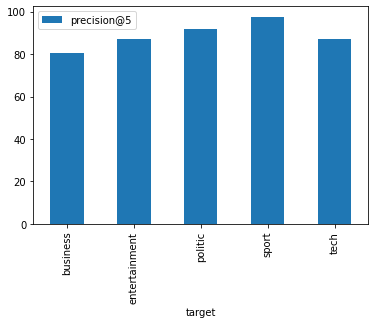

In [22]:
df_p5 = pd.DataFrame.from_dict(p5, orient='index', columns=['precision@5'])

df_p5["target"] =  target_names

d = df_p5.set_index("target")

d.plot.bar()

In [23]:
""" Gud resultados, mejores clases y peores """

' Gud resultados, mejores clases y peores '

## 3) Representación basada en word-embeddings y tf-idf

La segunda vectorización que vamos a usar representará los mensajes usando usando word-embeddings usando como los pesos tf-idf de cada palabra. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test.

Calcula la precisión@5 de cada una de las clases usando como consultas los documentos de la partición de test y la similitud del coseno. Vamos a considerar que un documento recuperado es relevante cuando pertenezca a la misma clase que la consulta.

Dibuja los resultados en un diagrama de barras y compara los resultados con los del apartado anterior.

In [24]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('words.txt', binary=False, no_header=True)

In [25]:
we_vocabulary = list(model.key_to_index.keys())

In [26]:
vectorizer2 = CountVectorizer(vocabulary = we_vocabulary, stop_words='english', binary=False,ngram_range=(1,1))

In [27]:
train_data_vector2 = vectorizer2.fit_transform(x_train.Text)
test_data_vector2 = vectorizer2.transform(x_test.Text)

we_feature_names = vectorizer2.get_feature_names()

In [28]:
train_preprocessed2 = tfidfer.fit_transform(train_data_vector2)
test_preprocessed2 = tfidfer.transform(test_data_vector2)

In [29]:
p5_2 = mean_precisions_per_class(train_preprocessed2, x_train.Category, test_preprocessed2[:200,], x_test.Category[:200], 5)
    
p5_2

{'business': 80.45454545454545,
 'entertainment': 87.23404255319149,
 'politics': 91.72413793103448,
 'sport': 97.55102040816327,
 'tech': 87.09677419354838}

<AxesSubplot:xlabel='target'>

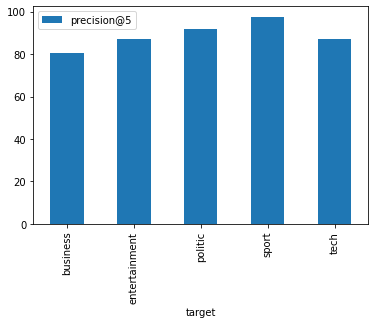

In [30]:
df_p5_2 = pd.DataFrame.from_dict(p5_2, orient='index', columns=['precision@5'])

df_p5_2["target"] =  target_names

d2 = df_p5_2.set_index("target")

d2.plot.bar()

## 4) Análisis de errores

Vamos a investigar los resultados para entender mejor dónde están fallando los procesos de recuperación. Sigue los siguientes pasos.


1. Identifica la categoría de noticias donde la precisión media haya mejorado más al incorporar word-embeddings
2. Para dicha categoría, identifica la consulta donde la precisión haya mejorado más al usar word-embeddings
3. Muestra el texto original de la consulta y los términos que aparecen en las dos vectorizaciones tf-idf que usamos (recuerda que usamos diccionarios distintos para las vectorizaciones bolsa de palabras y word-embeddings).
4. Identifica las noticias recuperadas para dicha consulta para las dos aproximaciones y sus categorías (TF-IDF puro y con word-embeddings)
5. Muestra la intersección de términos entre la consulta y la primera noticia mal recuperada usando TF-IDF puro.
6. Muestra la intersección de términos entre la consulta y la última noticia bien recuperada usando word-embeddings.
7. A la luz de todo lo anterior, razona sobre por qué crees que el TF-IDF no fue capaz de clasificar bien la noticia y el word-embedding sí.


Puedes usar el código que calcula la intersección de términos que ponemos a continuación

In [31]:
def terms_in_message(feature_names,vector_data,index):
    '''
    Devuelve un conjunto los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    mensaje=vector_data[index,:]>0
    terminos_presentes = ma.array(feature_names, mask = ~(mensaje[0].toarray()))

    return set(terminos_presentes.compressed())